<a href="https://colab.research.google.com/github/VaishnaviThirumala07/localrepo/blob/main/model_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Results for Grid Search XGBoost
✅ Accuracy: 0.9861
📉 RMSE: 0.1181
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3709
           1       0.98      0.98      0.98      2174

    accuracy                           0.99      5883
   macro avg       0.99      0.98      0.99      5883
weighted avg       0.99      0.99      0.99      5883



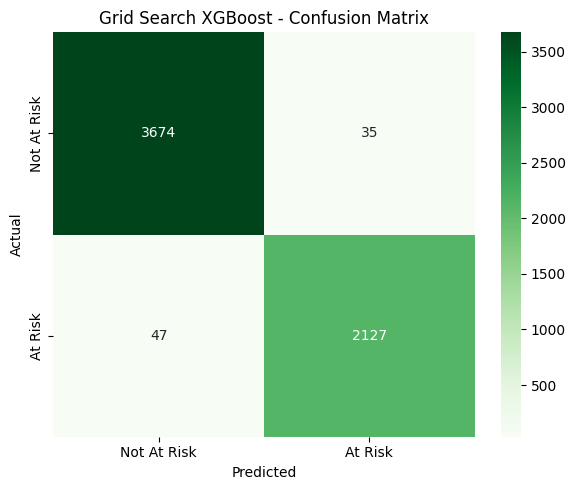


🔍 Results for Random Search XGBoost
✅ Accuracy: 0.9861
📉 RMSE: 0.1181
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3709
           1       0.98      0.98      0.98      2174

    accuracy                           0.99      5883
   macro avg       0.98      0.99      0.99      5883
weighted avg       0.99      0.99      0.99      5883



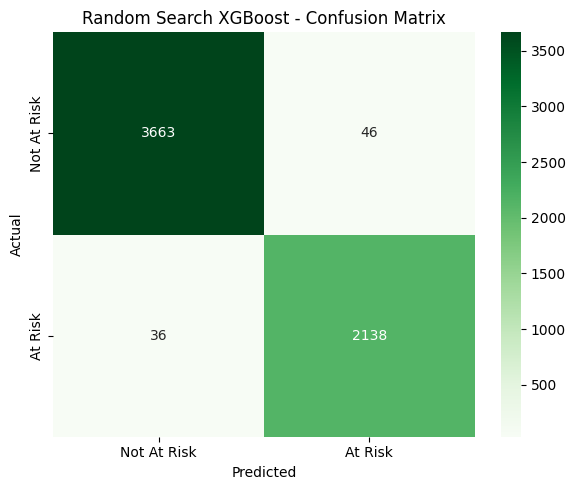


🔍 Results for Stacked Ensemble Model
✅ Accuracy: 0.9849
📉 RMSE: 0.1230
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3709
           1       0.98      0.98      0.98      2174

    accuracy                           0.98      5883
   macro avg       0.98      0.98      0.98      5883
weighted avg       0.98      0.98      0.98      5883



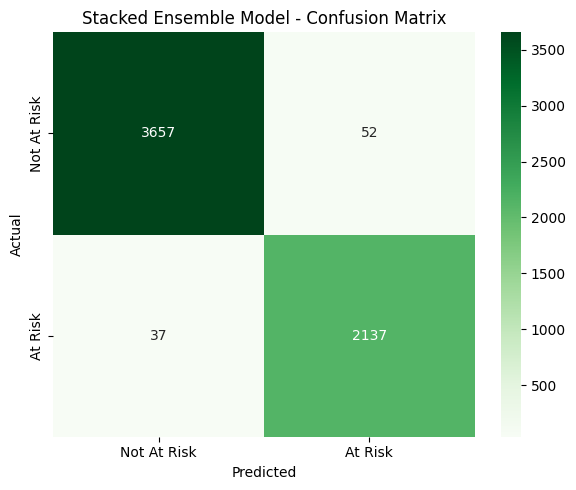

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

import xgboost as xgb
from scipy.stats import uniform, randint

# Load and prepare data
df = pd.read_csv("dataset.csv")
df['at_risk'] = pd.to_numeric(df['at_risk'], errors='coerce')
df.dropna(subset=['at_risk'], inplace=True)

X = df.drop(columns=['at_risk'])
y = df['at_risk'].astype(int)

# Encode categorical features
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# XGBoost base model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Grid Search
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Random Search
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=30, cv=3,
                                   scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best Models
best_grid_model = grid_search.best_estimator_
best_random_model = random_search.best_estimator_

# Evaluation Function
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n🔍 Results for {name}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"📉 RMSE: {rmse:.4f}")
    print("📊 Classification Report:\n", report)

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Not At Risk', 'At Risk'],
                yticklabels=['Not At Risk', 'At Risk'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Evaluate tuned models
evaluate_model(best_grid_model, "Grid Search XGBoost")
evaluate_model(best_random_model, "Random Search XGBoost")

# ---- Stacking Section ----

# Wrapper to use LinearRegression as Classifier
class LinearRegAsClassifier(LinearRegression):
    def predict(self, X):
        return (super().predict(X) > 0.5).astype(int)

# Base models for stacking
xgb_stack = best_random_model  # choose the better one from tuning
linear_model = LinearRegAsClassifier()
nn_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)

# Meta model
meta_model = LogisticRegression()

# Stacking classifier
stacked_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_stack),
        ('linear', linear_model),
        ('nn', nn_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# Train stacking model
stacked_model.fit(X_train, y_train)

# Evaluate stacked model
evaluate_model(stacked_model, "Stacked Ensemble Model")


In [5]:
import joblib

# Save models
joblib.dump(stacked_model, 'stacked_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')

# Optionally, save LabelEncoders if used
encoders = {}
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

joblib.dump(encoders, 'label_encoders.pkl')


['label_encoders.pkl']

In [6]:
from google.colab import files
files.download('stacked_model.pkl')
files.download('scaler.pkl')
files.download('feature_columns.pkl')
files.download('label_encoders.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>